## 8-a — Directional High-Pass Filtering

In this part, we apply **3×3 high-pass filters** to a grayscale satellite image to detect edges in specific orientations:
- **Horizontal edges**
- **Vertical edges**
- **Main diagonal edges (\\)**
- **Anti-diagonal edges (/)**

A high-pass filter emphasizes rapid intensity changes (edges) while suppressing smooth regions.  
By designing the kernel to be more sensitive in a specific direction, the filter will respond more strongly to edges aligned with that orientation.

### Algorithm:
1. **Load** the input grayscale image.
2. **Define** 3×3 kernels for each of the four directions.
3. **Apply** each kernel to the image using 2D convolution.
4. **Compute**:
   - The mean of the **absolute** filter response → indicates the overall strength of edges in that direction.
   - The **signed** mean of the response → shows any bias toward certain edge polarities.
5. **Interpret** the results:
   - A higher absolute mean value in a direction suggests that edges aligned with that orientation are more prevalent in the image.


In [34]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [53]:
image = Image.open("/mnt/e/Term 4/HW/DIP-HW2/data/q8/image.png")

In [54]:
properties = {
    'size': image.size,
    'mode': image.mode, # RGB or L(grayscale)
    'format': image.format,
    'type': type(image)
}

for key, value in properties.items():
    print(f'The {key} of image is: {value}')

The size of image is: (780, 727)
The mode of image is: L
The format of image is: PNG
The type of image is: <class 'PIL.PngImagePlugin.PngImageFile'>


In [55]:
# convert PngImageFile to ndarray
image = np.array(image).astype(np.float32)

(-0.5, 779.5, 726.5, -0.5)

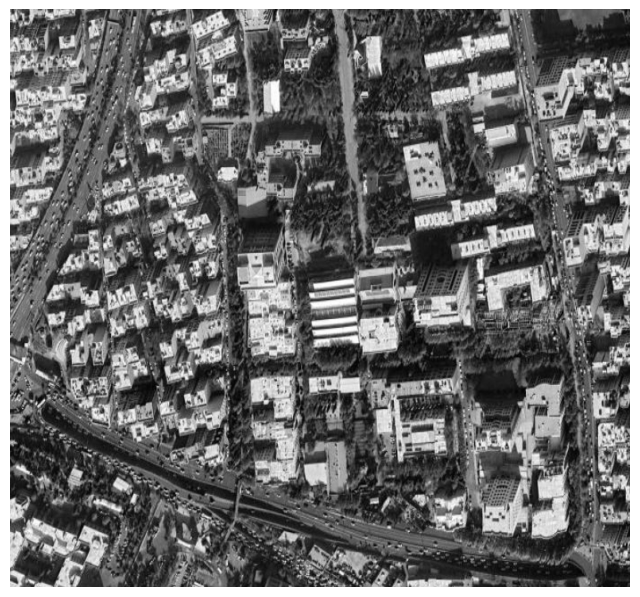

In [56]:
# image.show()

plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='grey')
plt.axis('off')

# 3x3 directional high-pass kernels (simple directional HPFs)

In [15]:
kernels = {
    'Horizontal edges': np.array([[-1, -1, -1],
                                  [ 2,  2,  2],
                                  [-1, -1, -1]], dtype=np.float32),
    'Vertical edges':   np.array([[-1,  2, -1],
                                  [-1,  2, -1],
                                  [-1,  2, -1]], dtype=np.float32),
    'Main diagonal': np.array([[ 2, -1, -1],
                                    [-1,  2, -1],
                                    [-1, -1,  2]], dtype=np.float32),
    'Anti-diagonal': np.array([[-1, -1,  2],
                                   [-1,  2, -1],
                                   [ 2, -1, -1]], dtype=np.float32)
}

In [16]:
filtered_images = {}
means_abs = {}
means_signed = {}

for filter_name, k in kernels.items():
    filtered_image = cv2.filter2D(image, ddepth=cv2.CV_32F, kernel=k)
    filtered_images[filter_name] = filtered_image
    means_abs[filter_name] = np.mean(np.abs(filtered_image))
    means_signed[filter_name] = np.mean(filtered_image)

origin_mean = np.mean(image)

In [24]:
filtered_images['Horizontal edges'].min()

-618.0

In [25]:
filtered_images['Horizontal edges'].max()

614.0

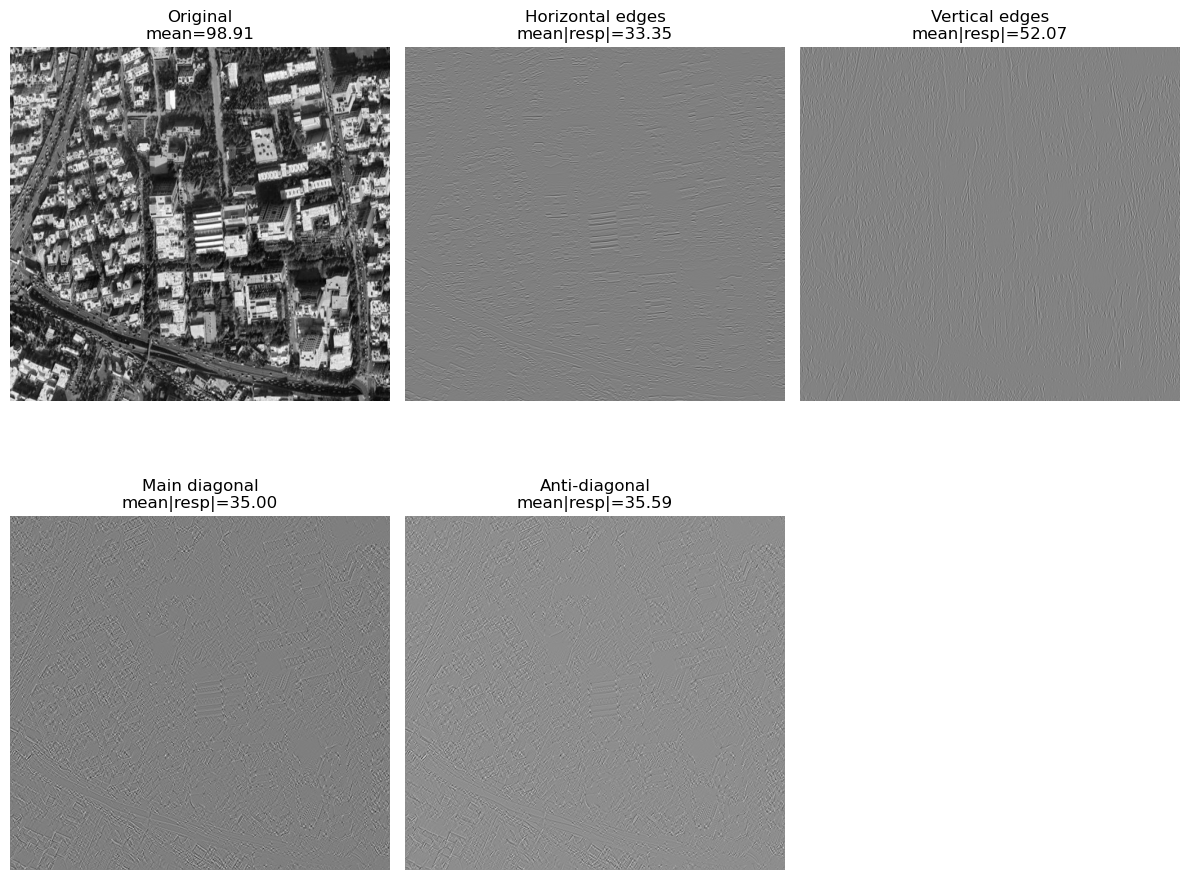

In [57]:
plt.figure(figsize=(12,10))
plt.subplot(2,3,1)
plt.imshow(image, cmap='gray')
plt.title(f'Original\nmean={origin_mean:.2f}')
plt.axis('off')

i = 2
for filtered_name, img in filtered_images.items():
    min, max = img.min(), img.max()
    normed_image = ((img - min)/(max - min)) * 255
    plt.subplot(2,3,i)
    plt.imshow(normed_image.astype(np.uint8), cmap='gray')
    plt.title(f'{filtered_name}\nmean|resp|={means_abs[filtered_name]:.2f}')
    plt.axis('off')
    i += 1


plt.tight_layout()
plt.show()

## 8-b — Standard Edge Detection Filters

In this part, we apply common edge-detection operators and compare them to the directional high-pass filters from 8-a:

- **Sobel** (horizontal and vertical): 3×3 kernels with weighted central differences, more robust to noise.
- **Prewitt** (horizontal and vertical): 3×3 kernels with uniform weights, simpler but more noise-sensitive.
- **Roberts Cross**: 2×2 kernels detecting diagonal intensity changes, suitable for fine edges.

### Algorithm:
1. Load the grayscale image.
2. Define the Sobel, Prewitt, and Roberts kernels for both horizontal and vertical detection.
3. Apply convolution to obtain horizontal (`Gx`) and vertical (`Gy`) responses.
4. Compute edge magnitude as:
   $
   M = \sqrt{G_x^2 + G_y^2}
   $
5. Compare the edge maps and mean magnitudes to those from part 8-a, noting differences in:
   - Edge sharpness
   - Noise sensitivity
   - Directional response


In [58]:
# Sobel
sobel_x = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
sobel_y = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)

sobel_mag = np.sqrt(sobel_x**2 + sobel_y**2)

In [61]:
# Prewitt
prewitt_kx = np.array([[-1, 0, 1],
                       [-1, 0, 1],
                       [-1, 0, 1]], dtype=np.float32)
prewitt_ky = np.array([[-1, -1, -1],
                       [ 0,  0,  0],
                       [ 1,  1,  1]], dtype=np.float32)

prewitt_x = cv2.filter2D(image, cv2.CV_32F, prewitt_kx)
prewitt_y = cv2.filter2D(image, cv2.CV_32F, prewitt_ky)
prewitt_mag = np.sqrt(prewitt_x**2 + prewitt_y**2)

In [62]:
# Roberts Cross
roberts_kx = np.array([[1, 0],
                       [0, -1]], dtype=np.float32)
roberts_ky = np.array([[0, 1],
                       [-1, 0]], dtype=np.float32)

roberts_x = cv2.filter2D(image, cv2.CV_32F, roberts_kx)
roberts_y = cv2.filter2D(image, cv2.CV_32F, roberts_ky)
roberts_mag = np.sqrt(roberts_x**2 + roberts_y**2)

In [63]:
means = {
    'Sobel': np.mean(sobel_mag),
    'Prewitt': np.mean(prewitt_mag),
    'Roberts': np.mean(roberts_mag)
}

In [64]:
print("Mean edge magnitudes:")
for k, v in means.items():
    print(f"{k}: {v:.4f}")

Mean edge magnitudes:
Sobel: 140.4722
Prewitt: 103.3591
Roberts: 31.0066


In [65]:
def normalize_for_display(img):
    rmin, rmax = img.min(), img.max()
    if rmax - rmin == 0:
        return np.zeros_like(img, dtype=np.uint8)
    return ((img - rmin) / (rmax - rmin) * 255).astype(np.uint8)

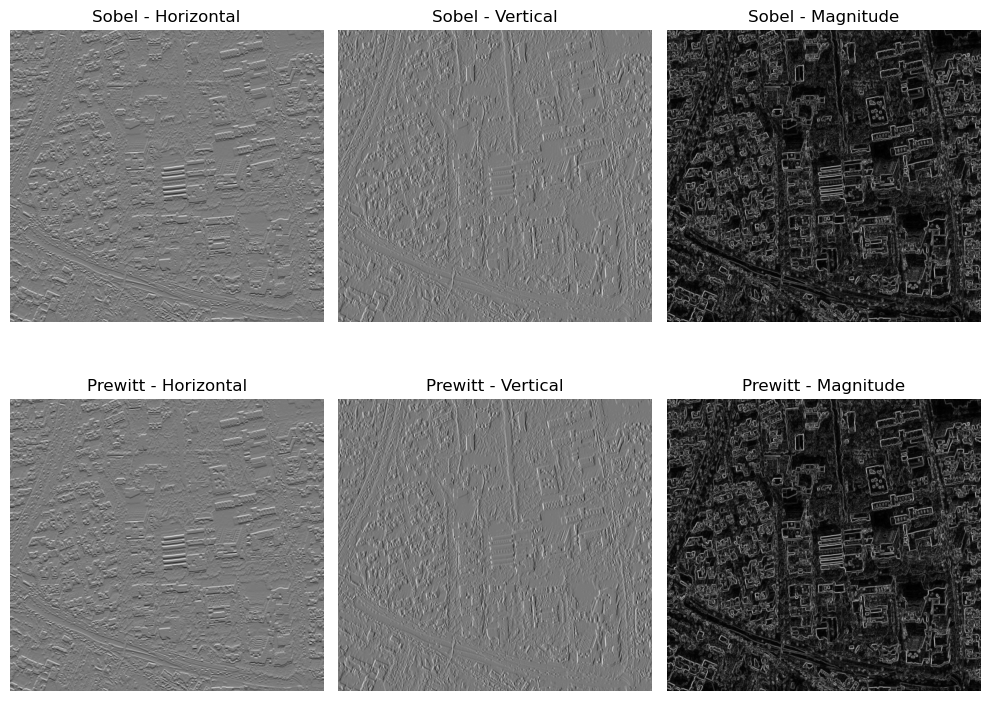

In [69]:
plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
plt.imshow(normalize_for_display(sobel_y), cmap='gray')
plt.title('Sobel - Horizontal')
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(normalize_for_display(sobel_x), cmap='gray')
plt.title('Sobel - Vertical')
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(normalize_for_display(sobel_mag), cmap='gray')
plt.title('Sobel - Magnitude')
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(normalize_for_display(prewitt_y), cmap='gray')
plt.title('Prewitt - Horizontal')
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(normalize_for_display(prewitt_x), cmap='gray')
plt.title('Prewitt - Vertical')
plt.axis('off')

plt.subplot(2,3,6)
plt.imshow(normalize_for_display(prewitt_mag), cmap='gray')
plt.title('Prewitt - Magnitude')
plt.axis('off')

plt.tight_layout()
plt.show()


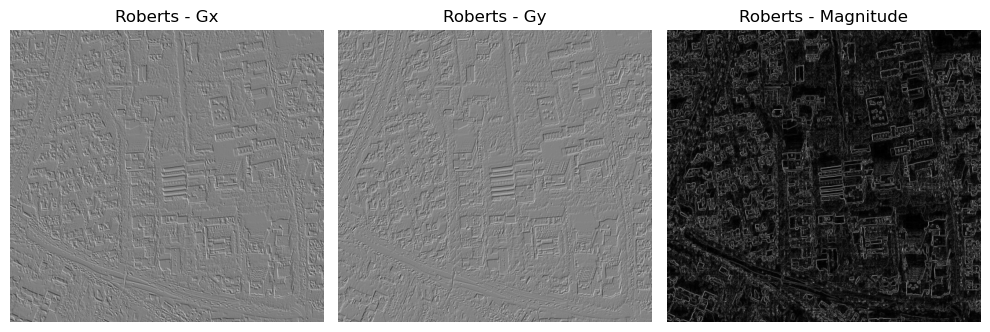

In [70]:
plt.figure(figsize=(10, 4))
plt.subplot(1,3,1)
plt.imshow(normalize_for_display(roberts_y), cmap='gray')
plt.title('Roberts - Gx')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(normalize_for_display(roberts_x), cmap='gray')
plt.title('Roberts - Gy')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(normalize_for_display(roberts_mag), cmap='gray')
plt.title('Roberts - Magnitude')
plt.axis('off')

plt.tight_layout()
plt.show()